# Exemple script for reading MAIA cloud product files.

MAIA files can be created with AAPP with scripts MAIA4_RUN and MAIA4_RUN_AVHRR scripts

for BOTH VIIRS an AVHRR imagers

- Install satpy and pyresample
- pycoast can also be installed if you want to generate plots with coast lines
- Here is an example of a minimal script that reads MAIA files

MAIA files are named with a specific syntax for example:

   - avhCT_M02_GL_20151012_S005503_E005802_DES_D_La-11_Lo0126_00000.h5
    
   - viiCT_npp_DB_20121010_S132824_E132947_ASC_D_La050_Lo-012_00001.h5
    
References :   

https://nwpsaf.eu/site/software/aapp/

      [NWPSAF-MF-UD-003] DATA Formats
      
      [NWPSAF-MF-UD-009] MAIA version 4 Scientific User Manual
      
This example uses the MAIA cloud product which can be found in the MAIA4_test.tgz tar test case file available with the AAPP software.

In [25]:
%matplotlib inline
from satpy import Scene
from satpy.utils import debug_on
import numpy as np
from satpy.composites import PaletteCompositor
from satpy.writers import to_image
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

In [26]:
# define palette (matplotlib style)
cpool = ['#4e7791',  # not processed 0
         '#008c30',  # Cloud free land 1
         '#000000',  # Cloud free sea 2
         '#ffbbff',  # Snow over ice 3
         '#dda0dd',  # Sea ice 4
         '#ffa500',  # Very low cumuliforme 5      # non utilisé par maia
         '#ff6600',  # Very low no cumuliforme 6
         '#ffd800',  # Low cumuliforme 7           # non utilisé par maia
         '#ffa500',  # Low cumuliforme 8
         '#ffff00',  # Mid-level cumuliforme 9         # non utilisé par maia
         '#d8ff00',  # Mid-level no cumuliforme 10
         '#cccc00',  # High opaque cumuliforme 11    # on utilisé par maia
         '#d8b575',  # High opaque no cumuliforme 12
         '#ffffff',  # Very High opaque cumuliforme 13 # non utilisé par maia
         '#ffe0aa',  # Very High opaque no cumuliforme 14
         '#0000ff',  # Semi transp. thin 15
         "#00b2ff",  # Semi transp. meanly thick 16
         '#00ffe5',  # Semi transp. thick 17
         '#00ffb2',  # semi transp abobe others 18
         '#d800ff',  # fractionnal
         '#660f00',  # Not classified 20
         ]


In [27]:
# function to convert it in satpy style
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return [int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3)]


In [28]:
fnmaia = "/home/a001865/CLOUDWEEK/cloud_week_maia/avhCT_M01_GL_20180514_S085503_E085802_DES_D_La081_Lo0081_00000.h5"

In [29]:
maia_scene = Scene(sensor='avhrr', reader='maia', filenames=[fnmaia])
maia_scene.load(["CloudType", "ct", "cma", "cma_conf",
                     'opaq_cloud', "CloudTopPres", "CloudTopTemp", "Alt_surface"])

In [30]:
fpps = "/home/a001865/SAFNWC_PPS/export_osisaf_maia/S_NWC_CT_metopb_00000_20180514T0855030Z_20180514T0858030Z.nc"
pps_scene = Scene(sensor='avhrr', reader='nc_nwcsaf_pps', filenames=[fpps])

In [31]:
#dir(pps_scene)

In [32]:
pps_scene.all_dataset_names()
pps_scene.load(['ct'])
pps_scene.datasets
maia_scene.datasets['ct']

<xarray.DataArray (y: 1080, x: 2048)>
dask.array<shape=(1080, 2048), dtype=uint8, chunksize=(1080, 2048)>
Dimensions without coordinates: y, x
Attributes:
    origin:               GL
    file_type:            maia
    start_time:           2018-05-14 08:55:03
    wavelength:           None
    level:                None
    platform_name:        M01
    center_lat:           081
    _FillValue:           0
    modifiers:            ()
    name:                 ct
    calibration:          None
    center_lon:           0081
    orbit:                0
    coordinates:          ['Longitude', 'Latitude']
    polarization:         None
    end_time:             2018-05-14 08:58:02
    resolution:           None
    orbit_type:           DES_D
    area:                 Shape: (1080, 2048)\nLons: <xarray.DataArray (y: 10...
    ancillary_variables:  []

In [33]:
#pps_scene.all_dataset_names()

### using xarray plotting
The satpy data can be plotten with the method for xarray. Note it is not the normal PPS colormap.

[[nan nan nan ...  7.  7. 12.]
 [nan nan nan ...  7.  7. 12.]
 [nan nan nan ...  7.  7. 12.]
 ...
 [nan nan nan ...  7.  7.  7.]
 [nan nan nan ...  7.  7.  7.]
 [nan nan nan ...  7.  7.  7.]]


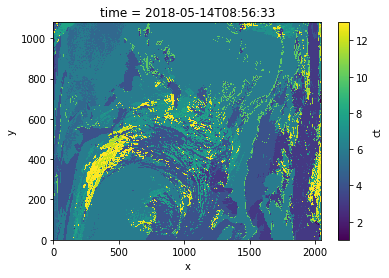

In [34]:
pps_scene.values()[0].plot() #using xarray plotting
array = pps_scene.values()[0]
print array.where(array > 5).values


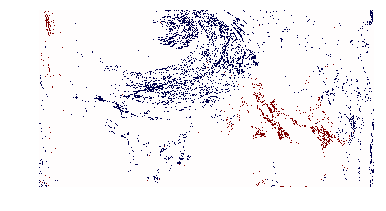

In [35]:
array_maia = maia_scene.datasets['ct']
pps_cmask = np.where(array > 4, 1, 0)
maia_cmask = np.where(array_maia > 4, 1, 0)
difference = pps_cmask - maia_cmask
plt.imshow(difference, cmap = 'seismic')
plt.axis('off')
ax = plt.gca()
ax.spines['right'].set_visible(False)
plt.savefig('difference.png')

In [36]:
#dir(pps_scene)

## Differences
For 94% of the pixels MAIA and PPS agree. For 1.2% of the pixels PPS is cloudy and MAIA is clear. For 5.3% MAIA is cloudy and PPS is clear. 

In [37]:
difference
print np.sum(difference>0)*100.0/np.size(difference)
print np.sum(difference<0)*100.0/np.size(difference)

1.192943431712963
5.290798611111111


## Command that did not work
#pps_scene.show("ct")

In [15]:
#maia_scene.all_dataset_names()


    The CloudType is a bit field containing the actual "ct" with values from 0 to 20
    which can be interpreted according to the cpool colormap

    "ct" can be display in black and white:


In [16]:
maia_scene.show("ct")
maia_scene.save_dataset("ct", filename="ct_bw.png")

<img src="ct_bw.png">

but it is better to palettize the image:

step 1: creation of the palette

In [17]:
mycolors = []
for i in range(21):
    mycolors.append(hex_to_rgb(cpool[i]))
arr = np.array(mycolors)
np.save("/tmp/binary_maia_ct_colormap.npy", arr)

In [18]:
np.__version__

'1.14.3'

In [19]:
!ls /tmp/binary_maia_ct_colormap.npy

/tmp/binary_maia_ct_colormap.npy


step2: creation of the composite

In [20]:
compositor = PaletteCompositor("test", standard_name="maia_ct")
composite = compositor((maia_scene["ct"], arr))
im_maia = to_image(composite)
im_maia.show()
im_maia.pil_save("ct.png")

<img src="ct.png">


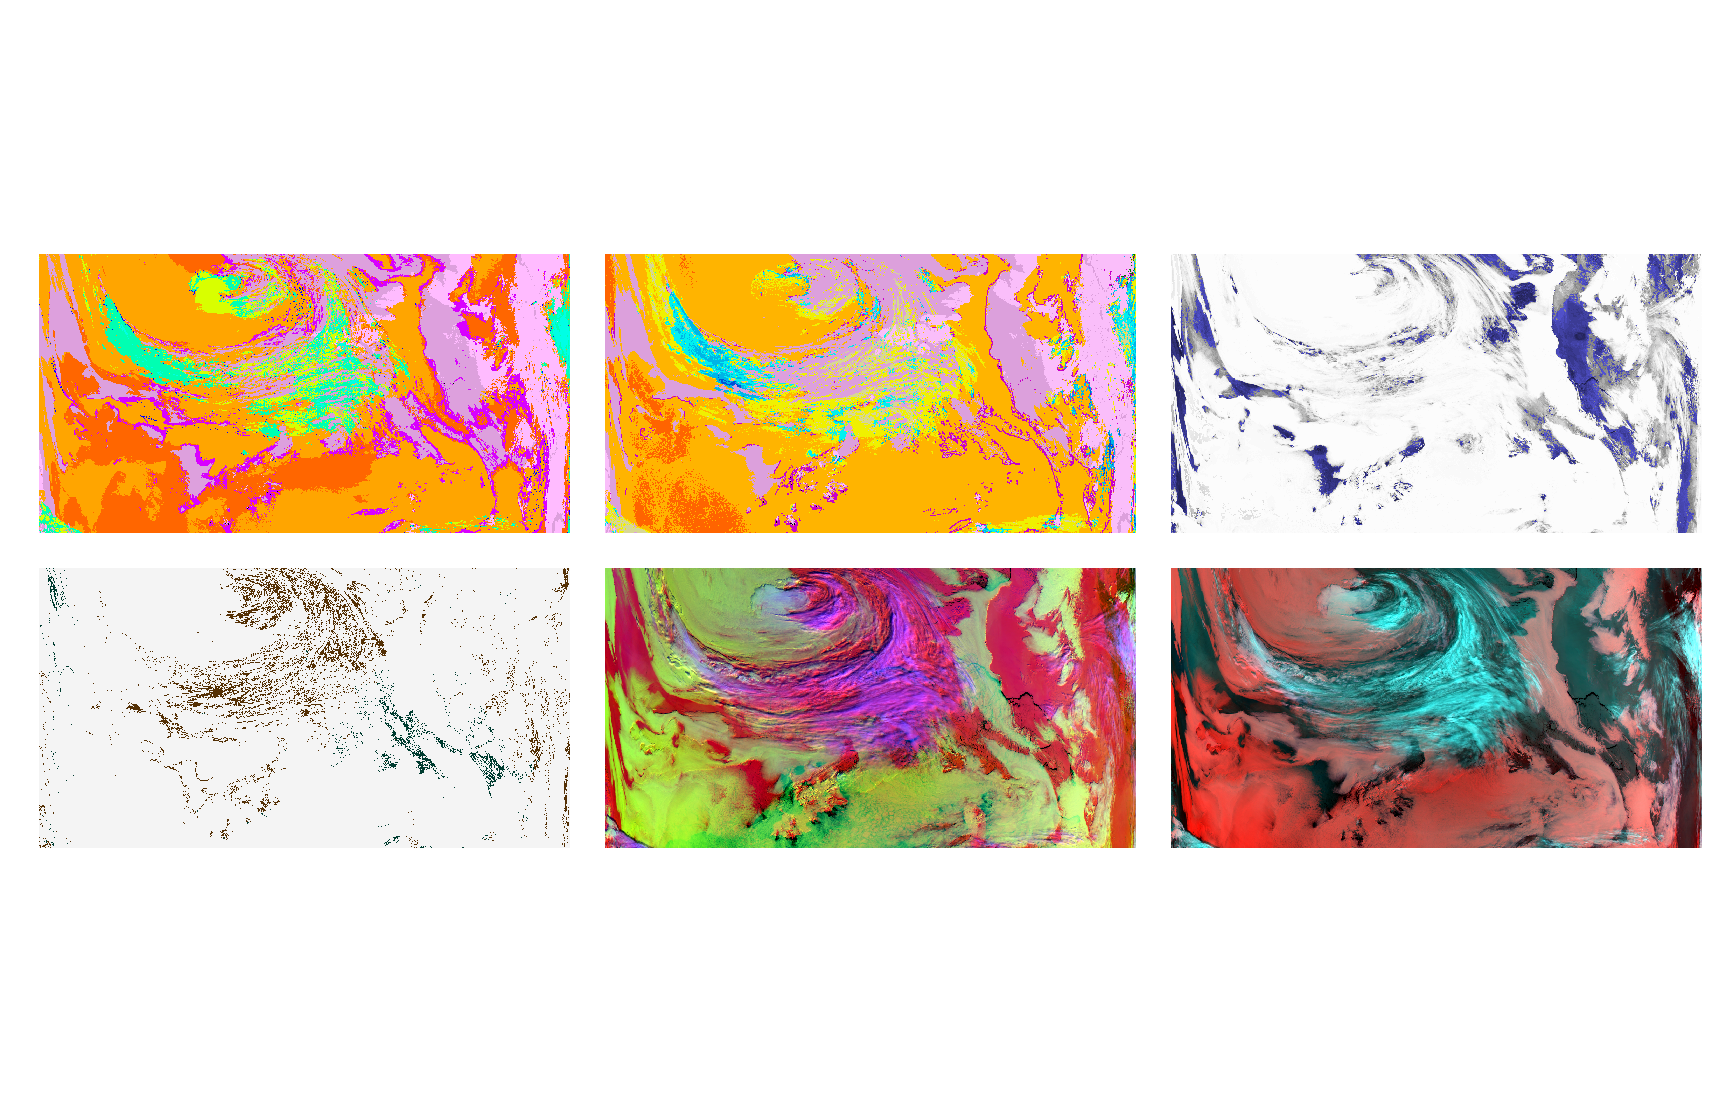

In [24]:
rgb_file = "S_NWC_avhrr_ch_06_16_11_metopb_00000_20180514T0855030Z_20180514T0858030Z.png"
rgb_file2 = "S_NWC_avhrr_ch_16_11_12_metopb_00000_20180514T0855030Z_20180514T0858030Z.png"

pps_png = "S_NWC_CT_metopb_00000_20180514T0855030Z_20180514T0858030Z.png"
pps_prob_png = "S_NWC_CMAPROB_metopb_00000_20180514T0855030Z_20180514T0858030Z.png"

im = Image.open(rgb_file)
im2 = Image.open(rgb_file2)

im_maia = Image.open('ct.png')
im_pps = Image.open(pps_png)
im_pps_prob = Image.open(pps_prob_png)

#im.show()
fig = plt.figure(figsize=(24, 15))

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
ax = fig.add_subplot(235)
ax.axis('off')
imshow(np.asarray(im))
ax = fig.add_subplot(236)
ax.axis('off')
imshow(np.asarray(im2))
ax = fig.add_subplot(231)
ax.axis('off')
imshow(np.asarray(im_maia))       
ax = fig.add_subplot(232)
ax.axis('off')
imshow(np.asarray(im_pps)) 
ax = fig.add_subplot(233)
ax.axis('off')
imshow(np.asarray(im_pps_prob)) 
ax = fig.add_subplot(234)
ax.axis('off')
imshow(difference) 
plt.tight_layout(pad=0,h_pad=-30)
#plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("merged_from_notebook.png",  bbox_inches='tight')

In [14]:
!ls /home/a001865/SAFNWC_PPS/export_osisaf_maia/S_NWC_avhrr_ch_06_16_11_metopb_00000_20180514T0855030Z_20180514T0858030Z.png

/home/a001865/SAFNWC_PPS/export_osisaf_maia/S_NWC_avhrr_ch_06_16_11_metopb_00000_20180514T0855030Z_20180514T0858030Z.png
